In [1]:
import sys, os
import serial
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import win32com.client
from astropy.io import fits
import threading
import nbimporter
from picoammeter_control import (
    send_cmd,
    query,
    init_cmds
)
from camera_control_ascom import (
    take_ramp,
    camera_init
)
sys.path.insert(0, os.path.abspath('.'))
sys.path.insert(0, os.path.abspath('filter_wheel_control'))
from filter_wheel_control.wheel_controller import (
    list_devices,
    open_device,
    get_position,
    get_position_count,
    set_position,
    close_device
)

In [2]:
# init filter wheels
print("Finding filter wheel devices...")
devices = list_devices()
if not devices:
    print("No filter wheel devices found.")
    sys.exit(1)

print("Found devices:")
for idx, dev in enumerate(devices):
    print(f" [{idx}] {dev}")


# init filter wheels to empty pos
for i in range(len(devices)):
    handle = open_device(devices[i])
    max_pos = get_position_count(handle)
    print(max_pos)
    if max_pos > 1:
        set_position(handle, 1)
        if max_pos == 6:
            wheel6_port = i
        elif max_pos == 12:
            wheel12_port = i
    close_device(handle)

Finding filter wheel devices...
No filter wheel devices found.


SystemExit: 1

C:\Users\Jonah\PycharmProjects\Image-Sensor-Testing-JK\venv\interpreter\lib\site-packages\IPython\core\interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
camera_init()

No camera detected


KEITHLEY INSTRUMENTS INC.,MODEL 6485,4070587,C01   Jun 23 2010 12:22:00/A02  /H
relative std: 8.946725833630763e-11


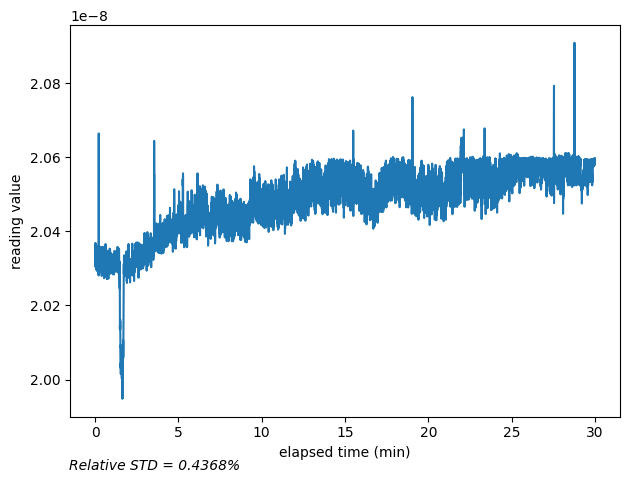

saved to path


In [25]:
""" to calculate picoammeter stability """
# Open serial connection
ser = serial.Serial(
    port='COM5',         # Replace with your actual port
    baudrate=9600,
    bytesize=serial.EIGHTBITS,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    timeout=2,
    xonxoff=False,
    rtscts=False,
    dsrdtr=False
)

init_cmds(ser)

# read_time = 30 # time in minutes to read for
# num_of_reads = round(417*read_time)
# readings = np.zeros(num_of_reads)
# times = np.zeros(num_of_reads)
#
# # Trigger a read and fetch result
# for i in range(num_of_reads):
#     time.sleep(0.004)
#     current = query(ser,'READ?')
#     readings[i] = current
#     times[i] = time.time()

read_time       = 30           # minutes
sample_interval = 0.004          # seconds between reads
start_time = time.time()
end_time   = start_time + read_time * 60
readings_1 = []
times_1    = []
while time.time() < end_time:
    time.sleep(sample_interval)
    current = query(ser, 'READ?')
    readings_1.append(current)
    times_1.append(time.time())

# Convert to NumPy arrays
readings = np.array(readings_1, dtype=float)
times    = np.array(times_1,    dtype=float)

mean_readings = np.mean(readings)
std_readings = np.std(readings)
rel_std = std_readings/mean_readings
print(f"relative std: {std_readings}")

elapsed = (times - times[0])/60.0
plt.plot(elapsed, readings)
plt.xlabel("elapsed time (min)")
plt.ylabel("reading value")
plt.subplots_adjust(bottom=0.15)
plt.figtext(0.25, 0.01,
            f"Relative STD = {rel_std:.4%}",
            ha="center", fontsize=10, fontstyle='italic')
plt.tight_layout()
plt.show()

import pandas as pd
df = pd.DataFrame({
    'time_min':       elapsed,
    'reading':        readings,
    'relative_std':   rel_std          # single value repeated
})
csv_path = f'picoam_readings_{read_time}_min.csv'
df.to_csv(csv_path, index=False)
print("saved to path")

ser.close()

In [ ]:
def picoam_worker(ser, stop_event, readings_list, times_list, sample_interval=0.004):
    """
    Continuously query the picoammeter until stop_event is set.
    Appends readings and timestamps into the provided lists.
    """
    while not stop_event.is_set():
        time.sleep(sample_interval)
        current = query(ser, 'READ?')
        readings_list.append(current)
        times_list.append(time.time())

def camera_with_picoam(cam_name, exp_low, exp_high, num_exp=10, num_frames=1, img_shape=(1000,1000),
              save_path=None, bit_depth=16, temp_setpoint=None):
    stop_evt      = threading.Event()
    picoam_readings = []   # plain Python lists so we can append indefinitely
    picoam_times    = []

    picoam_thread = threading.Thread(
        target=picoam_worker,
        args=(ser, stop_evt, picoam_readings, picoam_times),
    )
    picoam_thread.start()

    exp_times, img_array, img_times = take_ramp(cam_name, exp_low, exp_high, num_exp, num_frames, img_shape, save_path, bit_depth, temp_setpoint)

    stop_evt.set()
    picoam_thread.join()
    picoam_readings = np.array(picoam_readings)
    picoam_times = np.array(picoam_times)
    matched_readings = np.interp(img_times, picoam_times, picoam_readings)
    exp_flat = np.repeat(exp_times, num_frames)
    return exp_flat, matched_readings

In [ ]:
# Open serial connection
ser = serial.Serial(
    port='COM5',         # Replace with your actual port
    baudrate=9600,
    bytesize=serial.EIGHTBITS,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    timeout=2,
    xonxoff=False,
    rtscts=False,
    dsrdtr=False
)

init_cmds(ser)

cam_name = "ASCOM.ASICamera2.Camera"
exp_flat, matched_readings = camera_with_picoam(
        cam_name = cam_name,
        exp_low = 0.001,
        exp_high = 1.0,
        num_exp= 3,
        num_frames= 10,
        img_shape= (1000,1000),
        save_path= "C:/Users/cplay/CMOS_test_imgs/062325",
        bit_depth=16
    )

plt.figure()
plt.plot(exp_flat, matched_readings, 'o-')
plt.xlabel('Exposure Time (s)')
plt.ylabel('Picoammeter Current (A)')
plt.title('Picoammeter Current at Each Exposure')
plt.grid(True)
plt.tight_layout()
plt.show()

df = pd.DataFrame({
    'exposure_s': exp_flat,
    'picoam_current_A': matched_readings
})
csv_file = "camera_vs_pico.csv"
df.to_csv(csv_file, index=False)
print(f"Results saved to {csv_file}")